<a href="https://colab.research.google.com/github/Sahith-02/gtm_buddy_assignment/blob/main/GTM_BUDDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task - 1 : Data Preparation and Multi-Label Text Classification**

**Data Preparation**

In [ ]:
!pip install pandas scikit-learn transformers torch
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import json



def generate_synthetic_dataset(num_samples=150):
    # Predefined label combinations
    label_combinations = [
        ["Objection", "Pricing Discussion"],
        ["Security"],
        ["Competition"],
        ["Pricing Discussion"],
        ["Objection", "Competition"]
    ]

    # Predefined companies and products
    competitors = ["CompetitorX", "CompetitorY", "CompetitorZ"]
    features = ["analytics", "AI engine", "data pipeline", "machine learning", "reporting tools"]
    pricing_keywords = ["discount", "pricing", "cost", "budget", "subscription"]

    # Lists to store data
    ids = []
    text_snippets = []
    label_lists = []

    for i in range(num_samples):
        # Randomly select label combination
        snippet_labels = random.choice(label_combinations)

        # Construct snippet based on labels
        if "Objection" in snippet_labels:
            snippet = f"I'm hesitant about the pricing. {random.choice(competitors)} offers a cheaper solution."
        elif "Security" in snippet_labels:
            snippet = f"How secure is your platform? What compliance certifications do you have?"
        elif "Competition" in snippet_labels:
            snippet = f"How do you compare to {random.choice(competitors)} in terms of {random.choice(features)}?"
        elif "Pricing Discussion" in snippet_labels:
            snippet = f"Can we discuss {random.choice(pricing_keywords)} for our {random.choice(features)} needs?"
        else:
            snippet = "General discussion about our software requirements."

        # Append to lists
        ids.append(i+1)
        text_snippets.append(snippet)
        label_lists.append(", ".join(snippet_labels))

    # Create DataFrame
    df = pd.DataFrame({
        'id': ids,
        'text_snippet': text_snippets,
        'labels': label_lists
    })

    df.to_csv('calls_dataset.csv', index=False)
    return df

# Generate dataset
df = generate_synthetic_dataset(num_samples=150)
print(df.head())
print(df.shape)


domain_knowledge = {
    "competitors": [
        "CompetitorX",
        "CompetitorY",
        "CompetitorZ",
        "IndustryLeader",
        "StartupTech"
    ],
    "features": [
        "analytics",
        "AI engine",
        "data pipeline",
        "machine learning",
        "reporting tools",
        "predictive modeling",
        "real-time dashboards"
    ],
    "pricing_keywords": [
        "discount",
        "renewal cost",
        "budget",
        "pricing model",
        "subscription",
        "enterprise rate",
        "volume pricing"
    ]
}

# Write to JSON file
with open('domain_knowledge.json', 'w') as f:
    json.dump(domain_knowledge, f, indent=4)

# Verify the contents
with open('domain_knowledge.json', 'r') as f:
    print(json.load(f))

   id                                       text_snippet  \
0   1  How secure is your platform? What compliance c...   
1   2  How secure is your platform? What compliance c...   
2   3  Can we discuss cost for our reporting tools ne...   
3   4  I'm hesitant about the pricing. CompetitorX of...   
4   5  How do you compare to CompetitorX in terms of ...   

                          labels  
0                       Security  
1                       Security  
2             Pricing Discussion  
3  Objection, Pricing Discussion  
4                    Competition  
(150, 3)
{'competitors': ['CompetitorX', 'CompetitorY', 'CompetitorZ', 'IndustryLeader', 'StartupTech'], 'features': ['analytics', 'AI engine', 'data pipeline', 'machine learning', 'reporting tools', 'predictive modeling', 'real-time dashboards'], 'pricing_keywords': ['discount', 'renewal cost', 'budget', 'pricing model', 'subscription', 'enterprise rate', 'volume pricing']}


**Cleaning , Data Preprocessing and Data Augmentation**

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random
import re

# Custom stop words including domain-specific terms
STOP_WORDS = set(stopwords.words('english') + [
    'company', 'solution', 'product', 'service',
    'team', 'customer', 'vendor'
])

def advanced_preprocess(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove stop words
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS]

    return ' '.join(words)

# Data augmentation function
def augment_data(df):
    augmented_data = []

    # Identify minority labels
    label_counts = df['labels'].value_counts()
    minority_labels = label_counts[label_counts < label_counts.median()].index

    for _, row in df.iterrows():
        augmented_data.append(row)

        # Augment minority label rows
        if row['labels'] in minority_labels:
            # Synonym replacement or slight text modification
            augmented_text = row['text_snippet']
            augmented_text = augmented_text.replace('price', 'cost')
            augmented_text = augmented_text.replace('cheap', 'affordable')

            augmented_row = row.copy()
            augmented_row['text_snippet'] = augmented_text
            augmented_data.append(augmented_row)

    return pd.DataFrame(augmented_data)

# Apply preprocessing
df['processed_text'] = df['text_snippet'].apply(advanced_preprocess)

# Augment data
df_augmented = augment_data(df)

**Split the data into training,validation and test.**

In [ ]:
# Splits data into train (70%), validation (15%), test (15%)


from sklearn.model_selection import train_test_split

# Prepare features and labels
X = df_augmented['processed_text']
y = df_augmented['labels']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to multi-label format
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train.str.split(', '))
y_val_encoded = mlb.transform(y_val.str.split(', '))
y_test_encoded = mlb.transform(y_test.str.split(', '))

# Print dataset sizes
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))
print("Number of labels:", len(mlb.classes_))
print("Labels:", mlb.classes_)

Training set size: 141
Validation set size: 30
Test set size: 31
Number of labels: 4
Labels: ['Competition' 'Objection' 'Pricing Discussion' 'Security']


**Choosing a suitable multi-label classification approach:**

In [ ]:
# Install required libraries
!pip install scikit-learn pandas numpy transformers

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# Load previously generated dataset
df = pd.read_csv('calls_dataset.csv')

# Preprocess labels
df['labels'] = df['labels'].str.split(', ')

# Prepare MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df['labels'])

# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text_snippet'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Logistic Regression Classifier
lr_clf = MultiOutputClassifier(LogisticRegression(
    multi_class='ovr',
    max_iter=1000,
    class_weight='balanced'
))
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# Random Forest Classifier
rf_clf = MultiOutputClassifier(RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced'
))
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred, target_names=mlb.classes_))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=mlb.classes_))

# Micro F1 Scores
lr_f1 = f1_score(y_test, lr_pred, average='micro')
rf_f1 = f1_score(y_test, rf_pred, average='micro')
print(f"\nLogistic Regression Micro F1 Score: {lr_f1}")
print(f"Random Forest Micro F1 Score: {rf_f1}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Logistic Regression Classification Report:
                    precision    recall  f1-score   support

       Competition       0.62      1.00      0.77        10
         Objection       1.00      1.00      1.00        11
Pricing Discussion       0.69      1.00      0.81        11
          Security       1.00      1.00      1.00         9

         micro avg       0.79      1.00      0.88        41
         macro avg       0.83      1.00      0.90        41
      weighted avg       0.82      1.00      0.89        41
       samples avg       0.88      1.00      0.93        41


Random Forest Classification Report:
                    precision    recall  f1-score   support

       Competition       0.62      1.00      0.77        10
         Objection       1.00      1.00      1.00        11
Pricing Discussion       0.71      0.91      0.80        11
          Security       1.00      1.00      1.00         9

         micro avg       0.80      0.98      0.88        41
         macro

**Training your model**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

# Prepare data
df = pd.read_csv('calls_dataset.csv')
df['labels'] = df['labels'].str.split(', ')

# MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df['labels'])

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultiOutputClassifier(LogisticRegression()))
])

# Hyperparameter grid
param_grid = {
    'tfidf__max_features': [2000, 5000, 7000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__estimator__C': [0.1, 1, 10],
    'clf__estimator__penalty': ['l2'],
    'clf__estimator__max_iter': [1000, 2000]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_micro',
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(df['text_snippet'], y_encoded)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Detailed Cross-Validation Scores
cv_scores = cross_val_score(
    grid_search.best_estimator_,
    df['text_snippet'],
    y_encoded,
    cv=5,
    scoring='f1_micro'
)

print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# Save best model
import joblib
joblib.dump(grid_search.best_estimator_, 'best_multi_label_model.joblib')

Best Parameters: {'clf__estimator__C': 10, 'clf__estimator__max_iter': 1000, 'clf__estimator__penalty': 'l2', 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation Score: 0.8658278554997665

Cross-Validation Scores: [0.86486486 0.81395349 0.82926829 0.92105263 0.9       ]
Mean CV Score: 0.8658278554997665
Standard Deviation: 0.040610319629272834


['best_multi_label_model.joblib']

**Evaluation your model:**

Detailed Classification Report:
                    precision    recall  f1-score   support

       Competition       0.62      1.00      0.77        10
         Objection       1.00      1.00      1.00        11
Pricing Discussion       0.69      1.00      0.81        11
          Security       1.00      1.00      1.00         9

         micro avg       0.79      1.00      0.88        41
         macro avg       0.83      1.00      0.90        41
      weighted avg       0.82      1.00      0.89        41
       samples avg       0.88      1.00      0.93        41



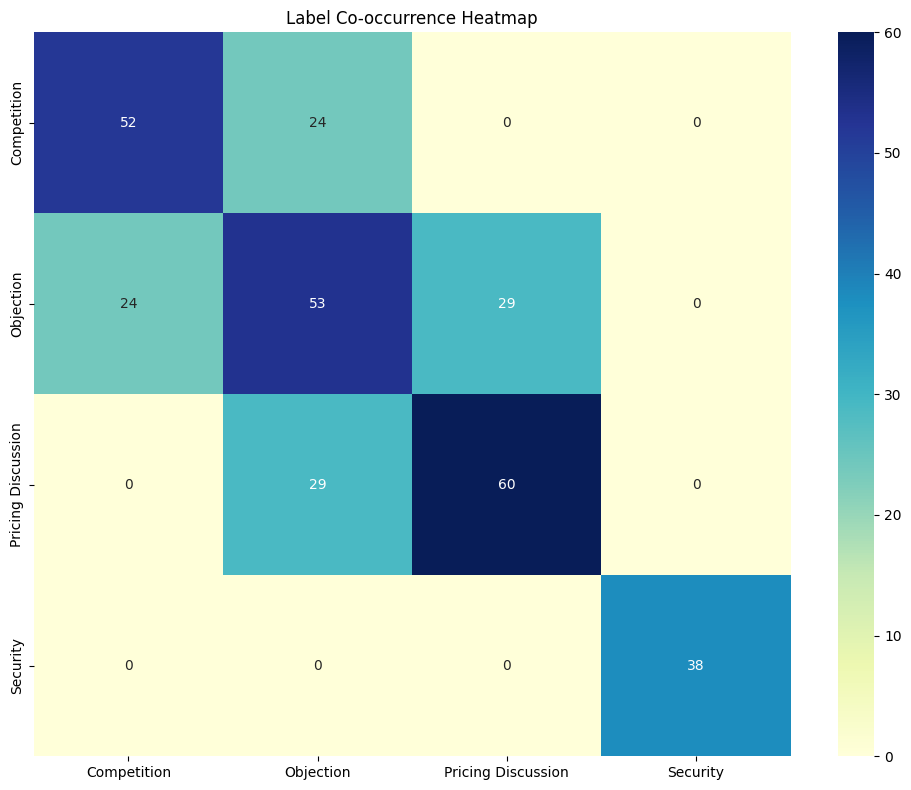

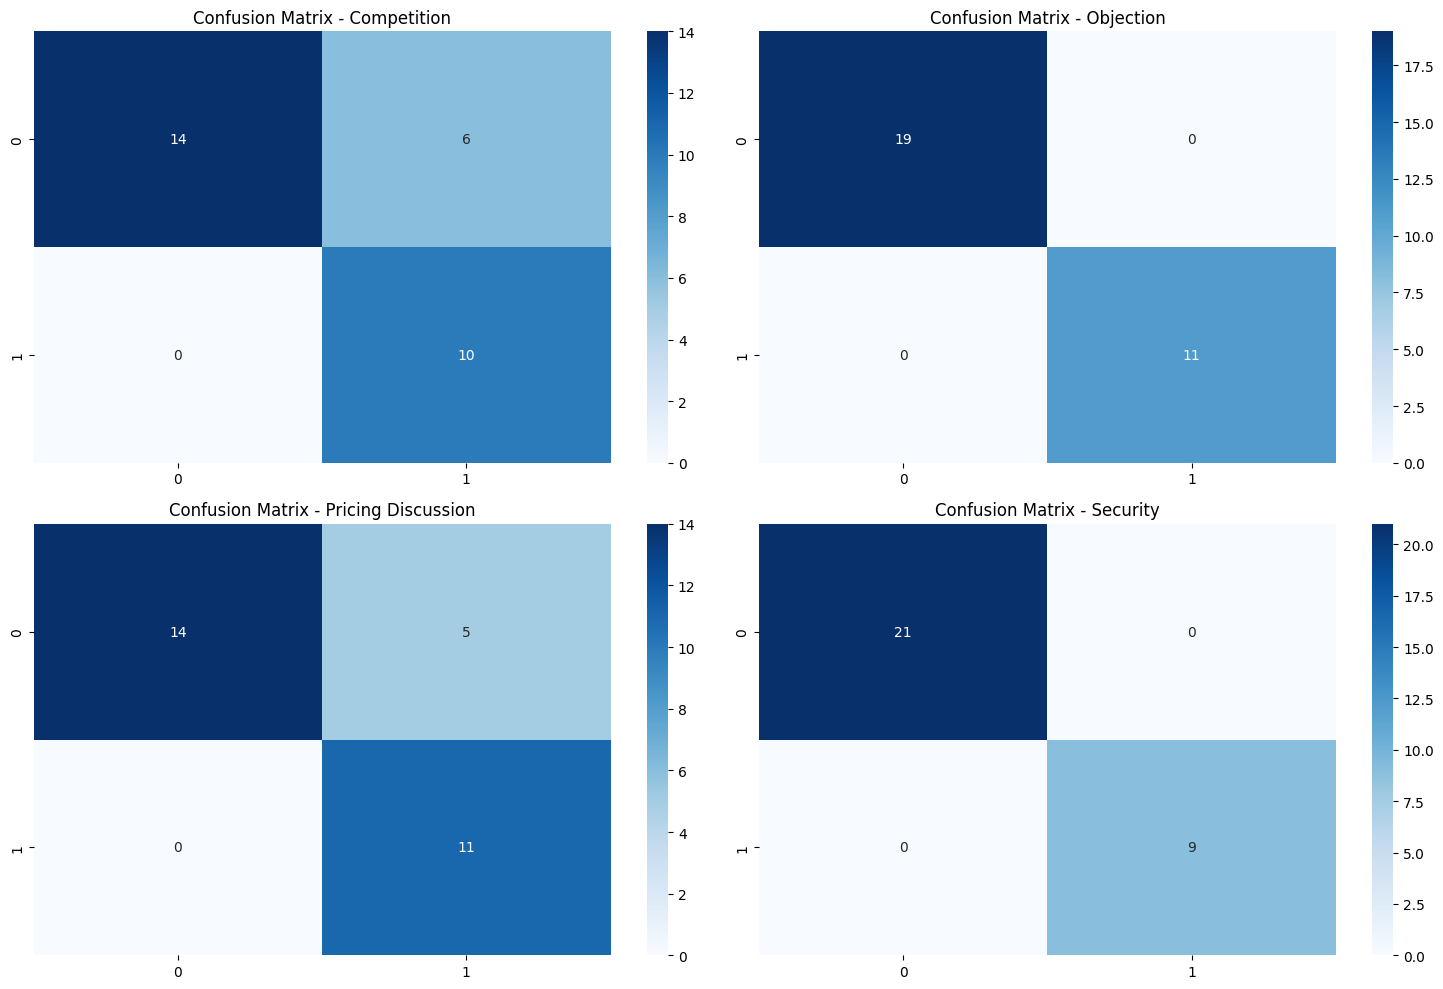

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

# Load and preprocess data
df = pd.read_csv('calls_dataset.csv')
df['labels'] = df['labels'].str.split(', ')

# Prepare MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df['labels'])

# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text_snippet'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train model
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Classification Report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Label Co-occurrence Heatmap
plt.figure(figsize=(10, 8))
label_cooccurrence = np.dot(y_encoded.T, y_encoded)
sns.heatmap(label_cooccurrence,
            annot=True,
            cmap='YlGnBu',
            xticklabels=mlb.classes_,
            yticklabels=mlb.classes_)
plt.title('Label Co-occurrence Heatmap')
plt.tight_layout()
plt.savefig('label_cooccurrence_heatmap.png')

# Per-label Confusion Matrices
plt.figure(figsize=(15, 10))
for i, label in enumerate(mlb.classes_):
    plt.subplot(2, 2, i+1)
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
plt.tight_layout()
plt.savefig('per_label_confusion_matrices.png')









**Task - 2 : Entity/Keyword Extraction with a Domain Knowledge Base**

**Dictionary Lookup**

In [ ]:
import json
import re
import pandas as pd
import spacy

class EntityExtractor:
    def __init__(self, domain_knowledge_path='domain_knowledge.json'):
        # Load domain knowledge
        with open(domain_knowledge_path, 'r') as f:
            self.domain_knowledge = json.load(f)

        # Load spaCy model for advanced NER
        self.nlp = spacy.load('en_core_web_sm')

    def dictionary_lookup(self, text):
        """Extract entities using dictionary lookup"""
        entities = {
            'competitors': [],
            'features': [],
            'pricing_keywords': []
        }

        # Check for each category
        for category, keywords in self.domain_knowledge.items():
            for keyword in keywords:
                if re.search(r'\b' + re.escape(keyword.lower()) + r'\b', text.lower()):
                    entities[category].append(keyword)

        return entities

    def spacy_ner(self, text):
        """Extract entities using spaCy NER"""
        doc = self.nlp(text)
        spacy_entities = {
            'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
            'products': [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT']
        }
        return spacy_entities

    def combine_entities(self, text):
        """Combine dictionary and spaCy entity extraction"""
        dict_entities = self.dictionary_lookup(text)
        spacy_entities = self.spacy_ner(text)

        combined_entities = {
            **dict_entities,
            **spacy_entities
        }

        return combined_entities

# Load dataset
df = pd.read_csv('calls_dataset.csv')

# Initialize extractor
extractor = EntityExtractor()

# Extract entities for each text snippet
df['extracted_entities'] = df['text_snippet'].apply(extractor.combine_entities)

# Display results
print(df[['text_snippet', 'extracted_entities']].head())

                                        text_snippet  \
0  How secure is your platform? What compliance c...   
1  How secure is your platform? What compliance c...   
2  Can we discuss cost for our reporting tools ne...   
3  I'm hesitant about the pricing. CompetitorX of...   
4  How do you compare to CompetitorX in terms of ...   

                                  extracted_entities  
0  {'competitors': [], 'features': [], 'pricing_k...  
1  {'competitors': [], 'features': [], 'pricing_k...  
2  {'competitors': [], 'features': ['reporting to...  
3  {'competitors': ['CompetitorX'], 'features': [...  
4  {'competitors': ['CompetitorX'], 'features': [...  


**NER**

In [ ]:
import pandas as pd
import spacy
import re
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline

class AdvancedEntityExtractor:
    def __init__(self, domain_knowledge_path='domain_knowledge.json'):
        # Load domain knowledge
        with open(domain_knowledge_path, 'r') as f:
            self.domain_knowledge = json.load(f)

        # Load SpaCy model
        self.nlp = spacy.load('en_core_web_sm')

        # Hugging Face NER pipeline
        self.ner_pipeline = pipeline("ner")

    def rule_based_extraction(self, text):
        """Rule-based entity extraction using regex and keyword matching"""
        entities = {
            'competitors': [],
            'features': [],
            'pricing_terms': []
        }

        # Custom regex patterns
        patterns = {
            'competitors': r'\b(CompetitorX|CompetitorY|CompetitorZ)\b',
            'features': r'\b(analytics|AI engine|data pipeline)\b',
            'pricing_terms': r'\b(discount|pricing|cost|budget)\b'
        }

        for category, pattern in patterns.items():
            entities[category] = re.findall(pattern, text, re.IGNORECASE)

        return entities

    def spacy_ner_extraction(self, text):
        """SpaCy Named Entity Recognition"""
        doc = self.nlp(text)
        entities = {
            'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
            'products': [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT'],
            'money': [ent.text for ent in doc.ents if ent.label_ == 'MONEY']
        }
        return entities

    def huggingface_ner_extraction(self, text):
        """Hugging Face NER Pipeline"""
        ner_results = self.ner_pipeline(text)
        entities = {
            'person': [],
            'organization': [],
            'location': []
        }

        for entity in ner_results:
            if entity['entity'] in ['B-PER', 'I-PER']:
                entities['person'].append(entity['word'])
            elif entity['entity'] in ['B-ORG', 'I-ORG']:
                entities['organization'].append(entity['word'])
            elif entity['entity'] in ['B-LOC', 'I-LOC']:
                entities['location'].append(entity['word'])

        return entities

    def combine_entity_extraction(self, text):
        """Combine multiple extraction techniques"""
        entities = {
            'rule_based': self.rule_based_extraction(text),
            'spacy_ner': self.spacy_ner_extraction(text),
            'huggingface_ner': self.huggingface_ner_extraction(text)
        }
        return entities

# Load dataset
df = pd.read_csv('calls_dataset.csv')

# Initialize extractor
extractor = AdvancedEntityExtractor()

# Extract entities for each text snippet
df['advanced_entities'] = df['text_snippet'].apply(extractor.combine_entity_extraction)

# Display results
print(df[['text_snippet', 'advanced_entities']].head())

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cpu


                                        text_snippet  \
0  How secure is your platform? What compliance c...   
1  How secure is your platform? What compliance c...   
2  Can we discuss cost for our reporting tools ne...   
3  I'm hesitant about the pricing. CompetitorX of...   
4  How do you compare to CompetitorX in terms of ...   

                                   advanced_entities  
0  {'rule_based': {'competitors': [], 'features':...  
1  {'rule_based': {'competitors': [], 'features':...  
2  {'rule_based': {'competitors': [], 'features':...  
3  {'rule_based': {'competitors': ['CompetitorX']...  
4  {'rule_based': {'competitors': ['CompetitorX']...  


**Combining both approaches**

In [ ]:
import pandas as pd
import json
import re
import spacy
from collections import defaultdict

class UnifiedEntityExtractor:
    def __init__(self, domain_knowledge_path='domain_knowledge.json'):
        # Load domain knowledge
        with open(domain_knowledge_path, 'r') as f:
            self.domain_knowledge = json.load(f)

        # Load SpaCy model
        self.nlp = spacy.load('en_core_web_sm')

    def dictionary_lookup(self, text):
        """Extract entities using dictionary lookup"""
        entities = defaultdict(list)

        for category, keywords in self.domain_knowledge.items():
            for keyword in keywords:
                if re.search(r'\b' + re.escape(keyword.lower()) + r'\b', text.lower()):
                    entities[category].append(keyword)

        return dict(entities)

    def spacy_ner_extraction(self, text):
        """Advanced SpaCy NER with custom domain mapping"""
        doc = self.nlp(text)
        entities = {
            'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
            'products': [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT'],
            'money_terms': [ent.text for ent in doc.ents if ent.label_ == 'MONEY']
        }
        return entities

    def combine_entities(self, text):
        """Merge entities from multiple extraction techniques"""
        # Get entities from dictionary lookup
        dict_entities = self.dictionary_lookup(text)

        # Get entities from SpaCy NER
        spacy_entities = self.spacy_ner_extraction(text)

        # Combine and deduplicate entities
        combined_entities = defaultdict(list)

        # Merge dictionary and SpaCy entities
        for category, values in dict_entities.items():
            combined_entities[category].extend(values)

        for category, values in spacy_entities.items():
            combined_entities[category].extend(values)

        # Remove duplicates
        for category in combined_entities:
            combined_entities[category] = list(set(combined_entities[category]))

        return dict(combined_entities)

# Load dataset
df = pd.read_csv('calls_dataset.csv')

# Initialize extractor
extractor = UnifiedEntityExtractor()

# Extract unified entities
df['extracted_entities'] = df['text_snippet'].apply(extractor.combine_entities)

# Display results
print(df[['text_snippet', 'extracted_entities']].head())

# Optional: Export results
df[['text_snippet', 'extracted_entities']].to_csv('extracted_entities.csv', index=False)

                                        text_snippet  \
0  How secure is your platform? What compliance c...   
1  How secure is your platform? What compliance c...   
2  Can we discuss cost for our reporting tools ne...   
3  I'm hesitant about the pricing. CompetitorX of...   
4  How do you compare to CompetitorX in terms of ...   

                                  extracted_entities  
0  {'organizations': [], 'products': [], 'money_t...  
1  {'organizations': [], 'products': [], 'money_t...  
2  {'features': ['reporting tools'], 'organizatio...  
3  {'competitors': ['CompetitorX'], 'organization...  
4  {'competitors': ['CompetitorX'], 'features': [...  


**Output of extracted entities**

In [ ]:
import pandas as pd
import json
from typing import Dict, List
import spacy
import re

class StructuredEntityExtractor:
    def __init__(self, domain_knowledge_path='domain_knowledge.json'):
        # Load domain knowledge
        with open(domain_knowledge_path, 'r') as f:
            self.domain_knowledge = json.load(f)

        # Load SpaCy model
        self.nlp = spacy.load('en_core_web_sm')

    def extract_entities(self, text: str) -> Dict[str, List[str]]:
        """Comprehensive entity extraction with structured output"""
        entities = {
            'domain_keywords': self._domain_keyword_extraction(text),
            'ner_entities': self._spacy_ner_extraction(text),
            'pricing_context': self._pricing_context_extraction(text)
        }
        return entities

    def _domain_keyword_extraction(self, text: str) -> Dict[str, List[str]]:
        """Extract keywords from domain knowledge"""
        domain_keywords = {}
        for category, keywords in self.domain_knowledge.items():
            found_keywords = [
                keyword for keyword in keywords
                if re.search(r'\b' + re.escape(keyword.lower()) + r'\b', text.lower())
            ]
            if found_keywords:
                domain_keywords[category] = found_keywords
        return domain_keywords

    def _spacy_ner_extraction(self, text: str) -> Dict[str, List[str]]:
        """Extract named entities using SpaCy"""
        doc = self.nlp(text)
        ner_entities = {
            'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
            'products': [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT'],
            'monetary_values': [ent.text for ent in doc.ents if ent.label_ == 'MONEY']
        }
        return {k: v for k, v in ner_entities.items() if v}

    def _pricing_context_extraction(self, text: str) -> Dict[str, str]:
        """Extract pricing and discussion context"""
        pricing_keywords = ['price', 'cost', 'budget', 'discount', 'expensive']
        pricing_context = {}

        # Check for pricing discussion presence
        if any(keyword in text.lower() for keyword in pricing_keywords):
            pricing_context['pricing_discussion'] = 'present'

        return pricing_context

# Load dataset
df = pd.read_csv('calls_dataset.csv')

# Initialize extractor
extractor = StructuredEntityExtractor()

# Extract structured entities
df['structured_entities'] = df['text_snippet'].apply(extractor.extract_entities)

# Display results
print(df[['text_snippet', 'structured_entities']].to_string())

# Optional: Export to JSON
df[['text_snippet', 'structured_entities']].to_json('structured_entities.json', orient='records')

                                                                 text_snippet                                                                                                                                                                  structured_entities
0    How secure is your platform? What compliance certifications do you have?                                                                                                                   {'domain_keywords': {}, 'ner_entities': {}, 'pricing_context': {}}
1    How secure is your platform? What compliance certifications do you have?                                                                                                                   {'domain_keywords': {}, 'ner_entities': {}, 'pricing_context': {}}
2                          Can we discuss cost for our reporting tools needs?                                                     {'domain_keywords': {'features': ['reporting tools']}, 'ner_entities': {}, 'pricing_context':